In [1]:
from math import exp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from functools import *

# Logistic Regression

In [3]:
def sigma(z):
    return(1 / (1 + np.exp(-z)))
def tanh(z):
    return((np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z)))
def relu(z):
    return(max(0,z))
def leaky_relu(z):
    return(max(0.01*z,z))

**For one sample tuple**

In [4]:
def LogRegCompute(x_1, x_2, w_1, w_2, b, alpha,y):
    def compute_da(y,a):
        da = -(y/a)+(1-y)/(1-a)
        return da
    def compute_dz(da,a):
        dz = da*a*(1-a)
        return dz
    def compute_d(dz, x=1):
        d = dz * x
        return d
    
    z = w_1*x_1 + w_2*x_2 + b
    a = sigma(z)
    
    da = compute_dz(y,a)
    dz = compute_dz(da,a)
    
    dw1 = compute_d(dz, x_1)
    dw2 = compute_d(dz, x_2)
    db = compute_d(dz)
    
    w_1 = w_1 + alpha*dw1
    w_2 = w_2 + alpha*dw2
    b = b + alpha*db
    return(w_1,w_2,b)

In [5]:
LogRegCompute(1,2,0,0,1,0.01,2)

(0.0007731250458590582, 0.0015462500917181165, 1.0007731250458591)

**For m samples, single step**

In [82]:
m = 1000
J_array, b = np.zeros((m,1)), 0
alpha = 0.01
np.random.seed(197)


w = np.zeros((1,2))
x_1 = np.random.randint(10, size = m).reshape(-1,m)
x_2 = np.random.randint(low = 25, high = 50, size = m).reshape(-1,m)
x = np.array([x_1,x_2]).reshape(2,m)

y = np.where(((x[1]<37.5) & (x[0]>5)), 1, 0)

for i in range(1000):
    z = np.zeros(m)
    a = np.zeros(m)

    z = np.dot(w,x) + b
    a = sigma(z)
    J = (-(y * np.log(a) + (1-y)* np.log(1-a))).mean()
    dz = a - y
    dw = (np.dot(x,dz.T).reshape(-1,2))/m
    db = dz.mean()
    w = w - alpha * dw
    b = b - alpha * db
    J_array[i] = J 

Text(0.5, 1.0, 'Cost function increase over 1000 iterations')

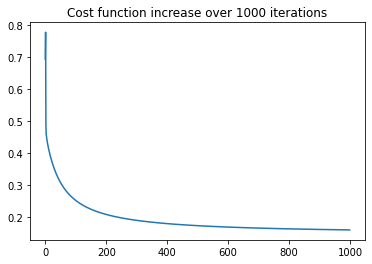

In [83]:
plt.plot(J_array)
plt.title("Cost function increase over 1000 iterations")

### Accuracy

In [84]:
z = np.dot(w,x) + b
a = sigma(z)
res = np.mean(np.where(a>0.5,1,0)==y)
print(f'Accuracy = {res*100}%')

Accuracy = 93.5%


# Neural Network 

#### Init network

In [94]:
def init_network():
    hidden_layer_nodes = []
    if(input("Load default input/output layer config: (y/n): ").lower()=='n'):
        input_layer_node = int(input("Enter number of nodes in input layer 0: "))
        n_layer = int(input("Enter number of layers in network: "))
        for i in range(1,n_layer):
            hidden_layer_nodes.append(input(f"Enter no. of nodes in layer {i}"))
        output_layer_node = int(input(f"Enter number of nodes in output layer {n_layer}: "))
    else:
        n_layer = 2
        input_layer_node = 2
        output_layer_node = 1
        hidden_layer_nodes = [4]  
    n__per_layer = [input_layer_node] + hidden_layer_nodes + [output_layer_node] 
    hidden_layers = {}
    for i in range(n_layer+1):
        hidden_layers[f'Layer {i}'] = {'a':np.zeros(shape=(n__per_layer[i],1))}
        hidden_layers[f'Layer {i}']['z'] = np.zeros(shape=(n__per_layer[i],1))
        if(i != 0):
            hidden_layers[f'Layer {i}']['w'] = np.zeros(shape=(n__per_layer[i],n__per_layer[i-1]))
            hidden_layers[f'Layer {i}']['b'] = np.zeros(shape=(n__per_layer[i],1))
    return(hidden_layers)

#### Display net 

In [93]:
def display_net(net, status = "original"):
    print(f'\nStatus: {status}\n')
    for key,value in net.items():
        print(f'{key}:')
        for key,value in value.items():
            print(f'{key}: \n{value}')

#### Forward prop

In [97]:

def forward_prop(net, x):
    n_layer = f'Layer {len(net)-1}'
    for key in net:
        if(key!='Layer 0'):
            w = net[key]['w']
            b = net[key]['b']
            if(key == n_layer):
                z = np.dot(w,a_prev) + b
                a = sigma(z)
            else:
                z = np.dot(w,a_prev) + b
                a = np.vectorize(relu)(z)
            net[key]['z'] = z 
            net[key]['a'] = a 
        a_prev = net[key]['a']
    return(net)

#### Back prop

In [101]:
def back_prop(net, y, i):
    net = dict(reversed(list(net.items())))
    n_layer = f'Layer {len(net)-1}'
    J = (-(y * np.log(net[n_layer]['a']) + (1-y)* np.log(1-net[n_layer]['a']))).mean()
    _net = list(net.items()) 
    dz = [[] for x in range(int(n_layer[-1]))]
    for j in range(len(_net)-1):
        a_curr = _net[j][1]['a']
        z_curr = _net[j][1]['z']
        
        a_next = _net[j+1][1]['a']
        if(j == 0):
            _dz = a_curr - y
        else:
            w_prev = _net[j-1][1]['w']
            dz_prev = dz[j-1]
            _dz = np.dot(w_prev.T,dz_prev) * z_curr*(1-z_curr)

        dw = np.dot(_dz,a_next.T)/m
        db = _dz.mean(axis = 1, keepdims = True) 
        _net[j][1]['w'] = _net[j][1]['w'] - alpha * dw 
        _net[j][1]['b'] = _net[j][1]['b'] - alpha * db
        dz[j] = _dz
    net = dict(reversed(_net))
    return(net,J)

#### Iteration

In [102]:
m = 1000
J_array, b = [], 0
alpha = 0.01
np.random.seed(197)

x_1 = np.random.randint(10, size = m).reshape(-1,m)
x_2 = np.random.randint(low = 25, high = 50, size = m).reshape(-1,m)
x = np.array([x_1,x_2]).reshape(2,m)

y = np.where(((x[1]<37.5) & (x[0]>5)), 1, 0).reshape(1,1000)

net = init_network()
net['Layer 0']['a'] = x

for i in range(1):
    net = forward_prop(net, x)
    net,J = back_prop(net,y, i)
    J_array.append(J)

display_net(net, "Output")

Load default input/output layer config: (y/n): y

Status: Output

Layer 0:
a: 
[[ 1  3  4 ...  0  9  2]
 [37 36 30 ... 28 26 35]]
z: 
[[0.]
 [0.]]
Layer 1:
a: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
z: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
w: 
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
b: 
[[0.]
 [0.]
 [0.]
 [0.]]
Layer 2:
a: 
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5

Text(0.5, 1.0, 'Cost function increase over 1000 iterations')

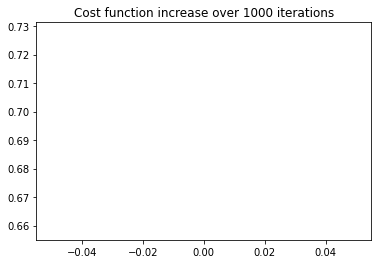

In [103]:
plt.plot(J_array)
plt.title("Cost function increase over 1000 iterations")

### Accuracy

In [90]:
n_layer = f'Layer {len(net)-1}'
for key,value in net.items():
    if(key!='Layer 0'):
        w = value['w']
        a = value['a']
        b = value['b']
        if(key == n_layer):
            z = np.dot(w,a_prev) + b
            a = sigma(z)
        else:
            z = np.dot(w,a_prev) + b
            a = np.vectorize(relu)(z)
        value['z'] = z 
        value['a'] = a 
    a_prev = value['a']
res = np.mean(np.where(net[n_layer]['a']>0.5,1,0)==y)
print(f'Accuracy = {res*100}%')

Accuracy = 80.0%


In [114]:
for i in range(len(list(net.items()))-1,0,-1):
    print(i)

2
1
